# Imports

In [4]:
import matplotlib.pyplot as plt

import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from tqdm import tqdm


random_seed = 1
torch.manual_seed(random_seed)

DATA_DIR = "C:\\Users\\Zayan\\Documents\\datasets\\time_image_classification"

# Time

This article shows how to prep data: https://www.kaggle.com/code/josemariasabater/it-s-all-about-time-simple-cnn-99-7-acc#Start-with-the-Neural-Network-part
This article shows how to build a model: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [5]:
df = pd.read_csv('C:\\Users\\Zayan\\Documents\\datasets\\time_image_classification\\clocks.csv')

In [6]:
df.head()

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  14400 non-null  int64 
 1   filepaths    14400 non-null  object
 2   labels       14400 non-null  object
 3   data set     14400 non-null  object
dtypes: int64(1), object(3)
memory usage: 450.1+ KB


In [8]:
num_classes = df['class index'].nunique() # number of classes
print(num_classes)

classes = df['class index'].unique()
print(classes[:5])

144
[0 1 2 3 4]


## Dataloader (Pytorch way)

This article explains everything: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
from typing import Any


class crop:
    def __call__(self, image):
        image.resize()

In [10]:
class TimeDataset(Dataset):
    '''
    Format of annotation:
    class index, filepaths, labels, data set
    0, train/1-00/0.jpg, 1_00, train
       '''
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        self.root_dir = root_dir
        self.annotations = pd.read_csv(f"{root_dir}\\{csv_file}") # read csv file as pandas dataframe
        self.transform = transform

        self.annotations["labels"] = self.annotations["labels"].str.replace("_", ":") # replace _ with : in the time column

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = io.imread(img_path)
        
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))
        time = self.annotations.iloc[index, 2]

        sample = {'image':image, 'label':y_label, 'time':time}

        if self.transform:
            sample['image'] = self.transform(sample["image"])

        return sample        

In [11]:
dataset = TimeDataset(csv_file='clocks.csv', root_dir=DATA_DIR, transform=transforms.ToTensor())

In [12]:
dataset[2]

{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'label': tensor(0),
 'time': '1:00'}

0 torch.Size([3, 224, 224])
class: 0, Time: 1:00


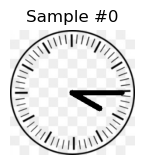

1 torch.Size([3, 224, 224])
class: 0, Time: 1:00


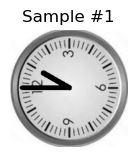

2 torch.Size([3, 224, 224])
class: 0, Time: 1:00


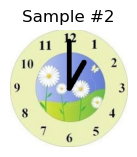

3 torch.Size([3, 224, 224])
class: 0, Time: 1:00


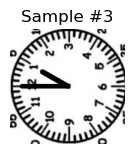

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
fig = plt.figure()

for i, sample in enumerate(dataset):
    print(i, sample['image'].shape)
    print(f"class: {sample['label']}, Time: {sample['time']}")

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [14]:
K = len(dataset)
print(K)

14400


Train set and test set

In [15]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7, 0.3])

data loader

In [16]:
batch_size = 35
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

Study the training data, a sample and a batch

--------------TRAINING DATA----------------
len of training data = 10080
number of batches = 288
---------------SAMPLE--------------
len of a sample =  3
sample feature data:
{'image': tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922]],

        [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922]],

   

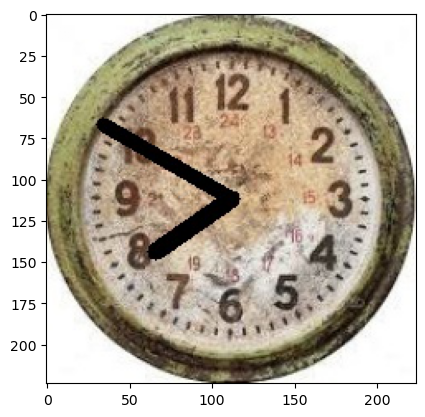

In [17]:
print("--------------TRAINING DATA----------------")
print("len of training data =", len(train_set))
print("number of batches =", len(train_loader)) # len(train_loader) produces the number of batches. Each item in train loader is a batch

print("---------------SAMPLE--------------")
print("len of a sample = ", len(train_set[0]))

print("sample feature data:")
print(train_set[0])

imshow(train_set[0]['image'])



-----------BATCH------------


{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.000

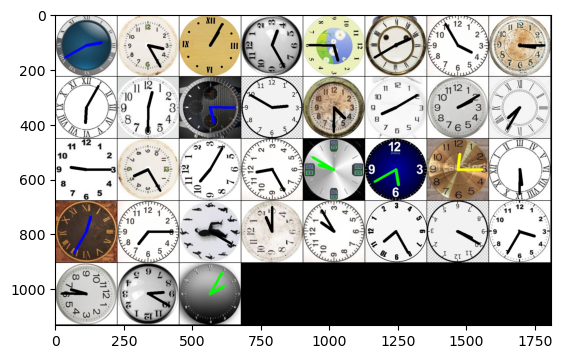

56 65 1 68 54 122 71 63 97 42 126 58 78 122 50 115 135 86 16 32 103 92 39 129 43 111 103 51 2 20 142 67 102 130 49


In [18]:
print("-----------BATCH------------")
batch_samples = next(iter(train_loader))
print(batch_samples)
print("batch size = ", len(batch_samples['image']))

print("--------------PLOT A BATCH-----------")
images = batch_samples['image']
labels = batch_samples['label']

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(batch_size)))

In [19]:
df[df['class index']==61]

,class index,filepaths,labels,data set
4880,61,train/3-05/0.jpg,3_05,train
4881,61,train/3-05/1.jpg,3_05,train
4882,61,train/3-05/10.jpg,3_05,train
4883,61,train/3-05/12.jpg,3_05,train
4884,61,train/3-05/13.jpg,3_05,train
...,...,...,...,...
13575,61,valid/3-05/47.jpg,3_05,valid
13576,61,valid/3-05/50.jpg,3_05,valid
13577,61,valid/3-05/51.jpg,3_05,valid
13578,61,valid/3-05/60.jpg,3_05,valid


In [20]:
for i, sample in enumerate(train_loader, 2):
    print(sample)
    if i==3:
        break

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.000

## CNN with pooling

This article has a basic model: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Manually coding layers and receptive fields

In [21]:
import torch
import torch.nn.functional as F

# Create a 255x255 tensor with random numbers
random_tensor = torch.rand((1, 1, 255, 255))

# Apply MaxPooling2D with kernel size 2
max_pooled_tensor = F.max_pool2d(random_tensor, kernel_size=2)

# Print the original and max-pooled tensors
print("Original Tensor:")
print(random_tensor.shape)
print("\nMax-Pooled Tensor:")
print(max_pooled_tensor.shape)


Original Tensor:
torch.Size([1, 1, 255, 255])

Max-Pooled Tensor:
torch.Size([1, 1, 127, 127])


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a random 255x255 tensor with 3 channels (e.g., representing an RGB image)
input_tensor_large = torch.rand((1, 3, 255, 255))
print("Input Tensor Shape:", input_tensor_large.shape)

# Define a convolutional layer
conv_layer_large = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
output_tensor_large = conv_layer_large(input_tensor_large)
print("Convolutional Layer Output Shape:", output_tensor_large.shape)

# Apply maxpool2d with kernel size 2 and stride 2
max_pooled_tensor_large_1 = F.max_pool2d(output_tensor_large, kernel_size=2, stride=2)
print("MaxPool2d (kernel_size=2, stride=2) Output Shape:", max_pooled_tensor_large_1.shape)

# Define another convolutional layer
conv_layer_large_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
output_tensor_large_2 = conv_layer_large_2(max_pooled_tensor_large_1)
print("Second Convolutional Layer Output Shape:", output_tensor_large_2.shape)

# Apply maxpool2d with kernel size 2 and stride 2 after the second convolutional layer
max_pooled_tensor_large_2 = F.max_pool2d(output_tensor_large_2, kernel_size=2, stride=2)
print("Second MaxPool2d (kernel_size=2, stride=2) Output Shape:", max_pooled_tensor_large_2.shape)

# Flatten the output tensor before passing it through the linear layer
flattened_tensor_large = max_pooled_tensor_large_2.view(-1, 16 * 60 * 60)  # Adjust based on the spatial dimensions
print("Flattened Tensor Shape:", flattened_tensor_large.shape)

# Define a linear layer with 120 outputs
linear_layer_large = nn.Linear(in_features=16 * 60 * 60, out_features=144)  # Adjust based on the spatial dimensions
linear_output_large = linear_layer_large(flattened_tensor_large)
print("Linear Layer Output Shape:", linear_output_large.shape)


Input Tensor Shape: torch.Size([1, 3, 255, 255])
Convolutional Layer Output Shape: torch.Size([1, 6, 251, 251])
MaxPool2d (kernel_size=2, stride=2) Output Shape: torch.Size([1, 6, 125, 125])
Second Convolutional Layer Output Shape: torch.Size([1, 16, 121, 121])
Second MaxPool2d (kernel_size=2, stride=2) Output Shape: torch.Size([1, 16, 60, 60])
Flattened Tensor Shape: torch.Size([1, 57600])
Linear Layer Output Shape: torch.Size([1, 144])


### Building the pytorch model

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # 3x224x224 -> 1x6x251x251
        self.pool1 = nn.MaxPool2d(2,2) # 1x6x125x125
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 1x16x121x121
        self.pool2 = nn.MaxPool2d(2,2) # 1x16x60x60
        self.fc1 = nn.Linear(16 * 53* 53, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        softmax = F.log_softmax(x, 1)
        return softmax

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

num_classes = 144
net = Net(num_classes).to(device)

cuda:0


In [24]:
# Dimensions after the second max-pooling layer
W_out4 = H_out4 = 60 / 2  # Adjusted for the pooling layer with kernel size 2
C_out4 = 16

# Size of the flattened tensor before the first fully connected layer
flattened_size = C_out4 * W_out4 * H_out4
print(flattened_size)


14400.0


In [26]:
# Create a random input tensor with a batch size of 20
input_tensor = torch.rand((20, 3, 224, 224)).to(device)  # Batch size of 20, 3 channels, 255x255 image
# Pass the input through each layer
conv1_output = F.relu(net.conv1(input_tensor))
pool1_output = net.pool1(conv1_output)
conv2_output = F.relu(net.conv2(pool1_output))
pool2_output = net.pool2(conv2_output)
flattened_output = torch.flatten(pool2_output, 1)
fc1_output = F.relu(net.fc1(flattened_output))
fc2_output = F.relu(net.fc2(fc1_output))
final_output = net.fc3(fc2_output)
softmax = F.softmax(final_output, 1)

# Print the shapes of the outputs
print("Conv1 Output Shape:", conv1_output.shape)
print("Pool1 Output Shape:", pool1_output.shape)
print("Conv2 Output Shape:", conv2_output.shape)
print("Pool2 Output Shape:", pool2_output.shape)
print("Flattened Output Shape:", flattened_output.shape)
print("FC1 Output Shape:", fc1_output.shape)
print("FC2 Output Shape:", fc2_output.shape)
print("Final Output Shape:", final_output.shape)
print("Softmax shape:", softmax.shape)

Conv1 Output Shape: torch.Size([20, 6, 220, 220])
Pool1 Output Shape: torch.Size([20, 6, 110, 110])
Conv2 Output Shape: torch.Size([20, 16, 106, 106])
Pool2 Output Shape: torch.Size([20, 16, 53, 53])
Flattened Output Shape: torch.Size([20, 44944])
FC1 Output Shape: torch.Size([20, 2000])
FC2 Output Shape: torch.Size([20, 500])
Final Output Shape: torch.Size([20, 144])
Softmax shape: torch.Size([20, 144])


Define loss function

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5)
num_epochs = 10

Training

In [28]:
for i, sample in enumerate(train_loader):
    print(sample)
    if i==2:
        break

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.000

In [34]:
num_epochs = 3
all_losses = []
mbls = []
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    batch_losses = []

    running_loss = 0.0
    for batch_idx, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.data.cpu().numpy())
        all_losses.append(loss.data.cpu().numpy())

        # print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    mbl = np.mean(np.sqrt(batch_losses)).round(3) # mean loss of all batch losses for this epoch
    mbls.append(mbl)

    print("Epoch [{}/{}], Batch loss: {}".format(epoch, num_epochs, mbl))

print('Finished Training')

  0%|          | 0/3 [00:00<?, ?it/s]

[1,   100] loss: 4.970


[1,   200] loss: 4.971


 33%|███▎      | 1/3 [00:33<01:06, 33.05s/it]

Epoch [0/3], Batch loss: 2.2290000915527344


[2,   100] loss: 4.970


[2,   200] loss: 4.970


 67%|██████▋   | 2/3 [01:04<00:32, 32.21s/it]

Epoch [1/3], Batch loss: 2.2290000915527344


[3,   100] loss: 4.970


[3,   200] loss: 4.971


100%|██████████| 3/3 [01:36<00:00, 32.13s/it]

Epoch [2/3], Batch loss: 2.2290000915527344
Finished Training


State dict

In [ ]:
# Print model's state_dict
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([2000, 44944])
fc1.bias 	 torch.Size([2000])
fc2.weight 	 torch.Size([500, 2000])
fc2.bias 	 torch.Size([500])
fc3.weight 	 torch.Size([144, 500])
fc3.bias 	 torch.Size([144])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'momentum': 0.5, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


Save model

In [ ]:
PATH = 'C:/Users/Zayan/Documents/code/personal_repos/neural_nets/models/CNN1.pth'
torch.save(net.state_dict(), PATH)

# Eval model

In [ ]:
loaded_net = Net(num_classes)
loaded_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

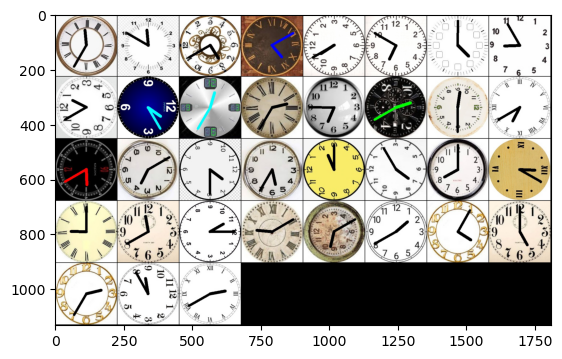

GroundTruth:  58 34 119 20 23 106 18 131 47 2 43 55 105 29 135 143 131 71 3 91 51 110 120 37 132 32 24 134 137 8 73 84 55 128 56


IndexError: index 15 is out of bounds for dimension 0 with size 15

In [ ]:
test_batch_samples = next(iter(test_loader))

images, labels, time = test_batch_samples['image'], test_batch_samples['label'], test_batch_samples['time']


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
outputs = loaded_net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}'
                              for j in range(batch_size)))

Predicted:  47 51 16 47 16 51 47 16 16 51 16 16 47 16 16 16 16 16 51 16 16 51 47 16 47 16 51 16 16 16 47 16 16 16 16


In [ ]:
next(iter(test_loader))

{'image': tensor([[[[0.9765, 0.9765, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
           [0.9765, 0.9725, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
           [0.9725, 0.9725, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.9882, 0.9882, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
           [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
           [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.9765, 0.9765, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
           [0.9765, 0.9725, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
           [0.9725, 0.9725, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.9882, 0.9882, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
           [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
           [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.9765, 0.9765, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
           [0.9765, 0.9725, 0.9725,  ..., 1.0000, 1.0000, 1.0000],
           [0.9

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch_idx, batch_data in enumerate(test_loader):
        images, labels = batch_data['image'], batch_data['label']
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 0 %


# Pretrained model performance

In [1]:
from torchvision import models

In [2]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [3]:
alexnet = models.alexnet(pretrained=True)
alexnet

c:\Users\Zayan\anaconda3\envs\ci_win\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Zayan\anaconda3\envs\ci_win\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Zayan/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:39<00:00, 6.19MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 